#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from data_loader import makeTensorLoaders

In [5]:
import copy

#### Test for CUDA

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Simulation parameters

In [7]:
N = 128 ## number of recurrent neurons
nsecs = 50 ## time
n_channels = 1

In [8]:
nRuns = 5

#### Train and test datasets

In [9]:
def random_assignment(numSamps, n, p):
    # Create a zero array of shape (numSamps, n)
    arr = np.random.choice([-1, 1], size=(numSamps, n))
    
    # Randomly assign 1 or -1 to elements with probability p
    rand_arr = np.random.random(arr.shape)
    arr[np.random.random(arr.shape) > p] = 0
    
    return arr

In [10]:
nTrain = 6000
nTest = 1000
prob_delta = 0.05

In [11]:
batch_size = 200

In [12]:
def flipflop_output(input_array):
    output_array = np.zeros_like(input_array)
    current_state = 0  # Track the current state
    
    for tt in range(len(input_array)):
        if input_array[tt] !=0:
            current_state = input_array[tt]
            output_array[tt:] = current_state
            
    return output_array

In [13]:
data_in_train = {}
data_in_test = {}

In [14]:
data_out_train = {}
data_out_test = {}

In [15]:
for cntr in range(nRuns):
    data_in_train[cntr] = random_assignment(nTrain, nsecs, prob_delta)
    data_in_test[cntr] = random_assignment(nTest, nsecs, prob_delta)
    
    data_out_train[cntr] = np.zeros_like(data_in_train[cntr])
    data_out_test[cntr] = np.zeros_like(data_in_test[cntr])
    
    for ii in range(nTrain):
        data_out_train[cntr][ii] = flipflop_output(data_in_train[cntr][ii])
        
    for ii in range(nTest):
        data_out_test[cntr][ii] = flipflop_output(data_in_test[cntr][ii])

In [16]:
train_loader = {}
test_loader = {}

In [17]:
for cntr in range(nRuns):
    train_loader[cntr] = makeTensorLoaders((data_in_train[cntr], data_out_train[cntr]), batch_size, shuffle=True)
    test_loader[cntr] = makeTensorLoaders((data_in_test[cntr], data_out_test[cntr]), batch_size, shuffle=False)

Text(0.5, 1.0, 'Flip-flop Task')

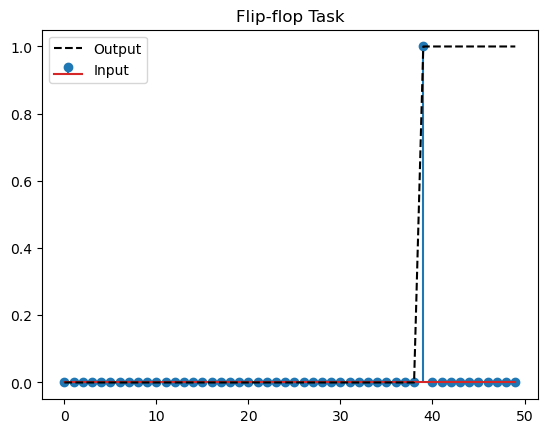

In [18]:
rr = 0
kk = 345 ## all zeros freaks it out

fex = plt.figure()
plt.stem(data_in_train[rr][kk],label='Input',markerfmt='o')
plt.plot(data_out_train[rr][kk],label='Output',color='k',linestyle='--')
plt.legend()
plt.title('Flip-flop Task')

#### Model and other hyper-params

In [19]:
num_layers = 1
input_size = n_channels
hidden_size = N
output_size = input_size

In [20]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [21]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [22]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size
        self.device = device

    def forward(self, x):
        m = nn.Tanh()
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.output_size, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = m(self.fc(ops[:, ii, :].clone()))
        
        return pred, htt

In [23]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [24]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [25]:
# Initialize the model
model = {}
weights_init = {}

In [26]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, output_size, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Dales Backprop')

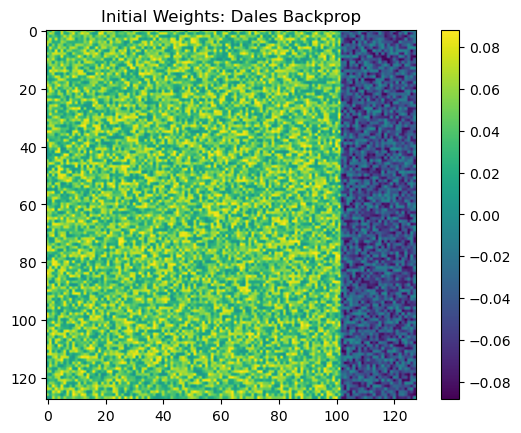

In [27]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Dales Backprop')

#### Model training

In [28]:
num_epochs = 100
learning_rate = 0.001

In [29]:
criterion = nn.MSELoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [30]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))

In [31]:
for run in tqdm(range(nRuns)):
    model[run].train()
    train_loss_min = np.Inf
    
    for epoch in range(1, num_epochs+1):
        print('Epoch: ',epoch)

        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader[run]:
            if train_on_gpu:
                inputs, targets = torch.unsqueeze(inputs.float().cuda(),-1), torch.unsqueeze(targets.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs, targets = torch.unsqueeze(inputs.float(),-1), torch.unsqueeze(targets.float(),-1)

            optimizer[run].zero_grad()
            outputs, firing_rates = model[run](inputs)
            if train_on_gpu:
                outputs = outputs.cuda()
            loss = criterion(outputs, targets)
            train_loss += loss.item()

            loss.backward()
            optimizer[run].step()

            ## Dale's backprop
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().to(device)

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[run][epoch-1] = train_loss

        for inputs_test, targets_test in test_loader[run]:
            if train_on_gpu:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float().cuda(),-1), torch.unsqueeze(targets_test.float().cuda(),-1)
                model[run].cuda()
            else:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float(),-1), torch.unsqueeze(targets_test.float(),-1)

            outputs_test, firing_rates_test = model[run](inputs_test)
            if train_on_gpu:
                outputs_test = outputs_test.cuda()
            loss_test = criterion(outputs_test, targets_test)
            test_loss += loss_test.item()
            
        test_losses[run][epoch-1] = test_loss

        print('Epoch: {}, Test Loss({:.6f})'.format(epoch,test_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->20.062793)
Epoch: 1, Test Loss(3.271032)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (20.062793-->17.702334)
Epoch: 2, Test Loss(3.341091)
Epoch:  3
Epoch: 3, Test Loss(3.047741)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (17.702334-->16.527777)
Epoch: 4, Test Loss(2.331816)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (16.527777-->14.222369)
Epoch: 5, Test Loss(2.139522)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (14.222369-->13.938878)
Epoch: 6, Test Loss(2.214357)
Epoch:  7
Epoch: 7, Test Loss(2.176518)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (13.938878-->13.913998)
Epoch: 8, Test Loss(2.128484)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (13.913998-->13.253051)
Epoch: 9, Test Loss(2.041786)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (13.253051-->13.194257)
Epoch: 10, Test Loss(2.020345)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (13.194257-->12.933964)
Epoch: 11, Test Loss(2.025352)
Epoch:  12
Epoch: 12, Test Loss(2.115025)
Epoch

 20%|██        | 1/5 [14:01<56:07, 841.96s/it]

Epoch: 100, Test Loss(0.002808)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.649545)
Epoch: 1, Test Loss(3.231151)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.649545-->19.073434)
Epoch: 2, Test Loss(3.002379)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (19.073434-->18.447017)
Epoch: 3, Test Loss(3.691285)
Epoch:  4
Epoch: 4, Test Loss(3.199510)
Epoch:  5
Epoch: 5, Test Loss(3.149162)
Epoch:  6
Epoch: 6, Test Loss(3.115752)
Epoch:  7
Epoch: 7, Test Loss(3.187819)
Epoch:  8
Epoch: 8, Test Loss(3.115639)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (18.447017-->18.326062)
Epoch: 9, Test Loss(2.885793)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (18.326062-->14.475683)
Epoch: 10, Test Loss(2.248480)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (14.475683-->11.497890)
Epoch: 11, Test Loss(1.867259)
Epoch:  12
Epoch: 12, Train Loss Decreased!! (11.497890-->10.176851)
Epoch: 12, Test Loss(1.870623)
Epoch:  13
Epoch: 13, Train Loss Decreased!! (10.176851-->9.911489)
Epoch: 13, Test Lo

Epoch: 96, Train Loss Decreased!! (0.014905-->0.014420)
Epoch: 96, Test Loss(0.002766)
Epoch:  97
Epoch: 97, Train Loss Decreased!! (0.014420-->0.013946)
Epoch: 97, Test Loss(0.002691)
Epoch:  98
Epoch: 98, Train Loss Decreased!! (0.013946-->0.013484)
Epoch: 98, Test Loss(0.002600)
Epoch:  99
Epoch: 99, Train Loss Decreased!! (0.013484-->0.013029)
Epoch: 99, Test Loss(0.002516)
Epoch:  100
Epoch: 100, Train Loss Decreased!! (0.013029-->0.012627)


 40%|████      | 2/5 [28:06<42:10, 843.40s/it]

Epoch: 100, Test Loss(0.002437)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.351057)
Epoch: 1, Test Loss(3.275747)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.351057-->16.976495)
Epoch: 2, Test Loss(2.817726)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (16.976495-->14.031105)
Epoch: 3, Test Loss(2.308659)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (14.031105-->13.173764)
Epoch: 4, Test Loss(2.127490)
Epoch:  5
Epoch: 5, Test Loss(3.273832)
Epoch:  6
Epoch: 6, Test Loss(3.259922)
Epoch:  7
Epoch: 7, Test Loss(3.254366)
Epoch:  8
Epoch: 8, Test Loss(3.247468)
Epoch:  9
Epoch: 9, Test Loss(3.253177)
Epoch:  10
Epoch: 10, Test Loss(3.246257)
Epoch:  11
Epoch: 11, Test Loss(3.210534)
Epoch:  12
Epoch: 12, Test Loss(3.196771)
Epoch:  13
Epoch: 13, Test Loss(3.158803)
Epoch:  14
Epoch: 14, Test Loss(3.131222)
Epoch:  15
Epoch: 15, Test Loss(3.075428)
Epoch:  16
Epoch: 16, Test Loss(3.119990)
Epoch:  17
Epoch: 17, Test Loss(2.934450)
Epoch:  18
Epoch: 18, Test Loss(2.926494)
Epoch:  

 60%|██████    | 3/5 [42:10<28:07, 843.51s/it]

Epoch: 100, Test Loss(0.001978)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->20.272461)
Epoch: 1, Test Loss(3.244796)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (20.272461-->17.578588)
Epoch: 2, Test Loss(2.491509)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (17.578588-->14.604882)
Epoch: 3, Test Loss(2.332170)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (14.604882-->13.994680)
Epoch: 4, Test Loss(2.306370)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (13.994680-->13.883576)
Epoch: 5, Test Loss(2.244886)
Epoch:  6
Epoch: 6, Test Loss(2.295310)
Epoch:  7
Epoch: 7, Test Loss(2.267164)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (13.883576-->13.806255)
Epoch: 8, Test Loss(2.250361)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (13.806255-->13.673437)
Epoch: 9, Test Loss(2.222464)
Epoch:  10
Epoch: 10, Test Loss(2.216391)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (13.673437-->13.380265)
Epoch: 11, Test Loss(2.161719)
Epoch:  12
Epoch: 12, Train Loss Decreased!! (13.380265-->12.566920)
Epoc

Epoch: 88, Test Loss(0.001772)
Epoch:  89
Epoch: 89, Train Loss Decreased!! (0.010574-->0.010241)
Epoch: 89, Test Loss(0.001719)
Epoch:  90
Epoch: 90, Train Loss Decreased!! (0.010241-->0.009914)
Epoch: 90, Test Loss(0.001669)
Epoch:  91
Epoch: 91, Train Loss Decreased!! (0.009914-->0.009617)
Epoch: 91, Test Loss(0.001619)
Epoch:  92
Epoch: 92, Train Loss Decreased!! (0.009617-->0.009328)
Epoch: 92, Test Loss(0.001576)
Epoch:  93
Epoch: 93, Train Loss Decreased!! (0.009328-->0.009043)
Epoch: 93, Test Loss(0.001525)
Epoch:  94
Epoch: 94, Train Loss Decreased!! (0.009043-->0.008772)
Epoch: 94, Test Loss(0.001483)
Epoch:  95
Epoch: 95, Train Loss Decreased!! (0.008772-->0.008508)
Epoch: 95, Test Loss(0.001440)
Epoch:  96
Epoch: 96, Train Loss Decreased!! (0.008508-->0.008257)
Epoch: 96, Test Loss(0.001402)
Epoch:  97
Epoch: 97, Train Loss Decreased!! (0.008257-->0.008023)
Epoch: 97, Test Loss(0.001363)
Epoch:  98
Epoch: 98, Train Loss Decreased!! (0.008023-->0.007786)
Epoch: 98, Test Loss

 80%|████████  | 4/5 [56:13<14:03, 843.65s/it]

Epoch: 100, Test Loss(0.001252)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->19.842429)
Epoch: 1, Test Loss(3.183443)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (19.842429-->18.412097)
Epoch: 2, Test Loss(2.423509)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (18.412097-->14.836264)
Epoch: 3, Test Loss(2.238591)
Epoch:  4
Epoch: 4, Test Loss(3.088398)
Epoch:  5
Epoch: 5, Test Loss(2.476761)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (14.836264-->14.058133)
Epoch: 6, Test Loss(1.949658)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (14.058133-->13.926131)
Epoch: 7, Test Loss(2.750024)
Epoch:  8
Epoch: 8, Test Loss(2.098268)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (13.926131-->11.895621)
Epoch: 9, Test Loss(1.664151)
Epoch:  10
Epoch: 10, Test Loss(2.949369)
Epoch:  11
Epoch: 11, Test Loss(2.805621)
Epoch:  12
Epoch: 12, Test Loss(2.718781)
Epoch:  13
Epoch: 13, Test Loss(2.509793)
Epoch:  14
Epoch: 14, Test Loss(2.568639)
Epoch:  15
Epoch: 15, Test Loss(2.055417)
Epoch:  16
Epoch: 16

Epoch: 99, Test Loss(0.003346)
Epoch:  100
Epoch: 100, Train Loss Decreased!! (0.022328-->0.021500)


100%|██████████| 5/5 [1:10:14<00:00, 842.96s/it]

Epoch: 100, Test Loss(0.003221)


In [32]:
outputs_np = outputs.detach().cpu().numpy()
targets_np = targets.detach().cpu().numpy()
firing_rates_np = firing_rates.detach().cpu().numpy()

In [33]:
outputs_test_np = outputs_test.detach().cpu().numpy()
targets_test_np = targets_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

Text(0.5, 1.0, 'Test')

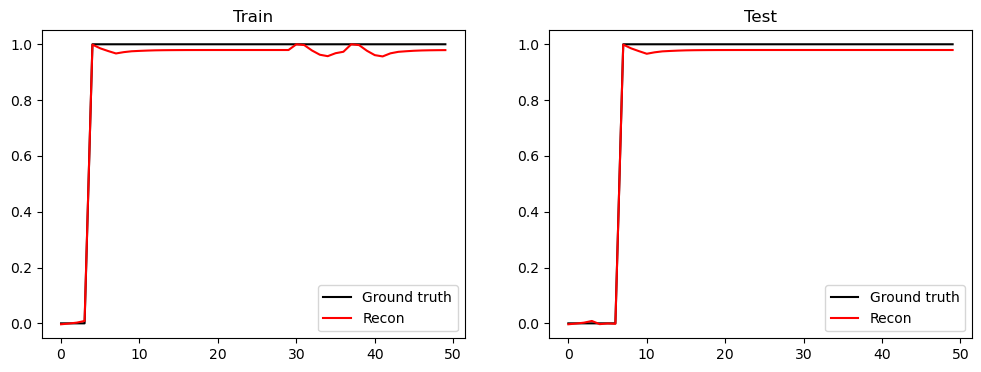

In [34]:
kk = 10 ## all zeros freaks it out

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(targets_np[kk],label='Ground truth',color='k')
plt.plot(outputs_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Train')

plt.subplot(122)
plt.plot(targets_test_np[kk],label='Ground truth',color='k')
plt.plot(outputs_test_np[kk],label='Recon',color='r')
plt.legend()
plt.title('Test')

In [35]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [36]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

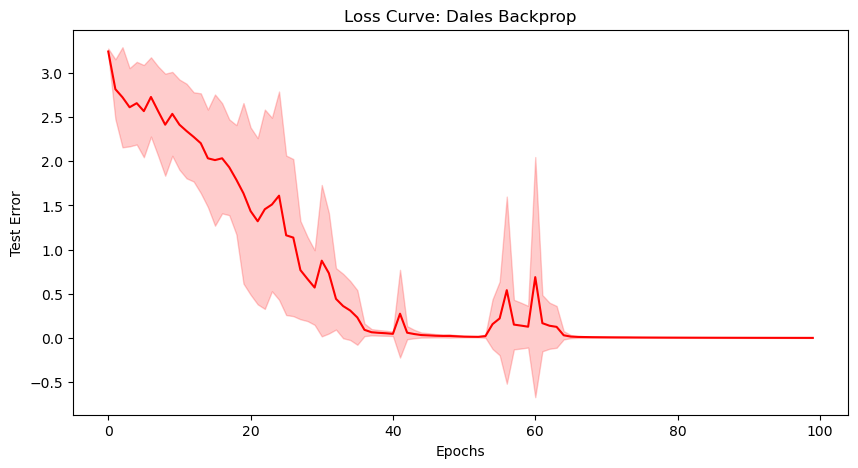

In [37]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=mean_train_losses, color='r')
# plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
#                  color='r', alpha=0.2)

sns.lineplot(x=x, y=mean_test_losses, color='r')
plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.title('Loss Curve: Dales Backprop')

# Show plot
plt.show()

## Pruning

#### Define functions

In [38]:
def random_prune(A, p):
    
    A += 1e-25
    
    # Ensure p is in the range [0, 1]
    p = max(0, min(1, p))
    # Adjust p based on the sparsity of the original matrix
    p_adjusted = -1.0 + np.sum(A!=0)/np.prod(A.shape) + p
    # Determine the threshold for setting elements to zero
    threshold = 1.0 - p_adjusted
    # Generate a random mask for sparsification
    mask = np.random.random(A.shape)
    # Set mask = 1 where A is already 0 and random elsewhere
    mask = np.where(A==0, 1, mask)
    # Apply the mask to the matrix to sparsify it
    sparsified_matrix = np.where(mask > threshold, A, 0)
    return sparsified_matrix

In [39]:
def distribute_equally(arr):
    
    r = np.sum(np.where(arr>1, arr-1, 0))
    
    while r>0:
        # Count number of probs less than 1
        count_less_than_one = sum(1 for num in arr if num < 1)
        # Estimate delta to be added per number
        delta = 0
        if count_less_than_one > 0:
            delta = r/count_less_than_one
        # return new array with delta added appropriately
        arr = np.where(arr<1, arr+delta, 1)
        # calculate new residue
        r = np.sum(np.where(arr>1, arr-1, 0))
    
    return arr

In [40]:
def topprob_prune(A, s):
    
    A += 1e-25
    
    N_post = A.shape[0]
    N_pre = A.shape[1]
    A_sparse = np.zeros_like(A)
    
    z0 = np.sum(A==0) + np.min((N_pre,N_post))
    if z0 > 0:
        z = s*np.prod(A.shape)
        s = (z-z0)/(np.prod(A.shape)-z0)
    
    if N_post == N_pre:
        D = -1*np.diag(np.diag(A))
        W = A #+ D
    else:
        d_vals = -1*np.diag(A)
        D = np.zeros_like(A)
        np.fill_diagonal(D, d_vals)
        W = A #+ D
    
    K = N_pre*N_post*(1-s)/np.sum(np.abs(W))
    Pmat = np.zeros_like(W)
    
    for ii in range(N_post):
        for jj in range(N_pre):
            
            if np.abs(W[ii,jj])>0:
                Pij = K*(np.abs(W[ii,jj]))
                Pmat[ii,jj] = Pij
    
    Pmat_adjusted = distribute_equally(Pmat.ravel())
    Pmat_adjusted = Pmat_adjusted.reshape(N_post, N_pre)
                
    for ii in range(N_post):
        for jj in range(N_pre):
            if np.abs(W[ii,jj])>0:
                Pij = Pmat_adjusted[ii,jj]    
                if np.random.uniform() < Pij:
                    A_sparse[ii,jj] = A[ii,jj]
    
    return A_sparse, K

#### Trials

In [41]:
rr = 0
prob_trial = 0.
s_trial = 1 - prob_trial

In [42]:
A_trial = weights_final[rr]

# trial with random pruning
A_trial_random = random_prune(A_trial,prob_trial)

## trial with topprob pruning
A_trial_topprob, _ = topprob_prune(A_trial,s_trial)

In [43]:
print(np.sum(A_trial_random==0)/N**2)
print(np.sum(A_trial_topprob==0)/N**2)

1.0
1.0


#### Prune using final weights

In [44]:
prob_list = np.linspace(1e-2, 1, 14)
prob_list = np.hstack((np.zeros(1),prob_list))
s_list = 1-prob_list

In [45]:
print('Conn probs = ', prob_list)
print('--------------------------------')
print('--------------------------------')
print('Sparisties = ', s_list)

Conn probs =  [0.         0.01       0.08615385 0.16230769 0.23846154 0.31461538
 0.39076923 0.46692308 0.54307692 0.61923077 0.69538462 0.77153846
 0.84769231 0.92384615 1.        ]
--------------------------------
--------------------------------
Sparisties =  [1.         0.99       0.91384615 0.83769231 0.76153846 0.68538462
 0.60923077 0.53307692 0.45692308 0.38076923 0.30461538 0.22846154
 0.15230769 0.07615385 0.        ]


In [46]:
n = len(prob_list)

sparsities_list_random = np.zeros((nRuns,n))
sparsities_list_topprob = np.zeros((nRuns,n))

A_pruned_list_random = np.zeros((nRuns,n,N,N))
A_pruned_list_topprob = np.zeros((nRuns,n,N,N))

errors_list_random = np.zeros((nRuns,n))
errors_list_topprob = np.zeros((nRuns,n))

In [47]:
# Initialize the model
mp_random = {}
mp_topprob = {}

In [48]:
for run in tqdm(range(nRuns)):
    A = weights_final[run]
    
    mp_random[run] = copy.deepcopy(model[run])
    mp_topprob[run] = copy.deepcopy(model[run])
    
    for ii, pp in enumerate(prob_list):
        ss = s_list[ii]
        A_pruned_list_random[run,ii] = random_prune(A,pp)
        A_pruned_list_topprob[run,ii], _ = topprob_prune(A,ss)
        
        sparsities_list_random[run,ii] = np.sum(A_pruned_list_random[run,ii]==0)/N**2
        sparsities_list_topprob[run,ii] = np.sum(A_pruned_list_topprob[run,ii]==0)/N**2
        
        mp_random[run].rnn.weight_hh_l0.data = mp_random[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_random[run,ii]).cuda())
        op_random, frp = mp_random[run](inputs_test)
        errors_list_random[run,ii] = criterion(op_random.cuda(), targets_test)
        
        mp_topprob[run].rnn.weight_hh_l0.data = mp_topprob[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_topprob[run,ii]).cuda())
        op_topprob, frp = mp_topprob[run](inputs_test)
        errors_list_topprob[run,ii] = criterion(op_topprob.cuda(), targets_test)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|██████████| 5/5 [00:51<00:00, 10.37s/it]


In [49]:
xtick_labels = [str(np.round(k,3)) for k in prob_list]
xtick_positions = np.arange(len(prob_list))

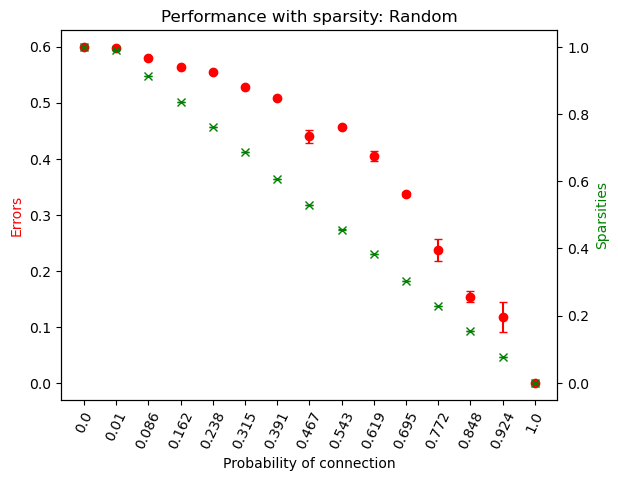

In [50]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.var(errors_list_random,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.var(sparsities_list_random,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Random')
ax.set_xlabel('Probability of connection')
plt.show()

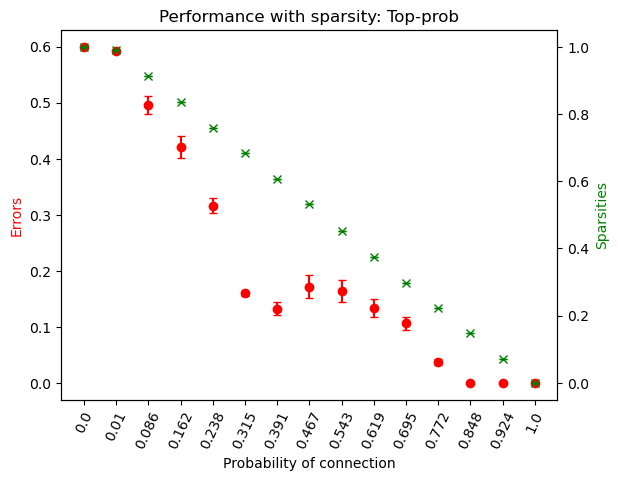

In [51]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.var(errors_list_topprob,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.var(sparsities_list_topprob,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Top-prob')
ax.set_xlabel('Probability of connection')
plt.show()

Text(0.5, 1.0, 'Sparsity vs. Probability of connection')

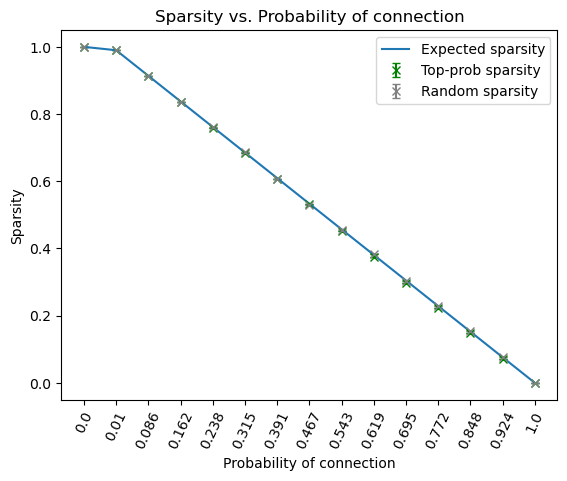

In [52]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.var(sparsities_list_topprob,0),
             fmt='x', capsize=3, color='g', label='Top-prob sparsity')
plt.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.var(sparsities_list_random,0),
             fmt='x', capsize=3, color='grey', label='Random sparsity')
plt.plot(np.arange(len(prob_list)), s_list, label = 'Expected sparsity')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Sparsity')
plt.xlabel('Probability of connection')
plt.title('Sparsity vs. Probability of connection')

Text(0.5, 0, 'Connection probabilities')

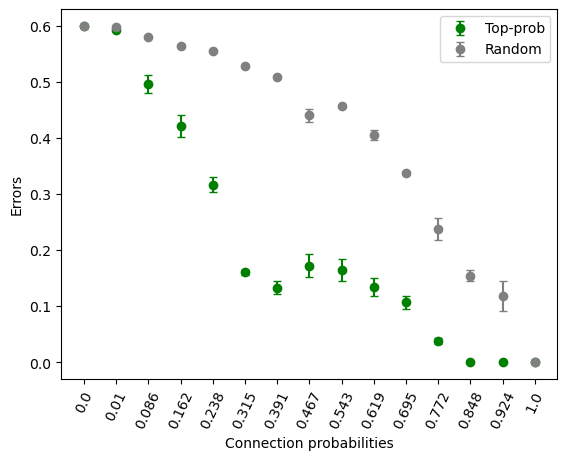

In [53]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.var(errors_list_topprob,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.var(errors_list_random,0),
             fmt='o', capsize=3, color='grey', label='Random')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Connection probabilities')

In [54]:
# np.save('errors_list_random_flipflop.npy',errors_list_random)
# np.save('errors_list_topprob_flipflop.npy',errors_list_topprob)

In [55]:
means = [np.mean(errors_list_topprob), np.mean(errors_list_random)]
devs = [np.var(errors_list_topprob), np.var(errors_list_random)]

In [56]:
labels = ['Top-prob','Random']
x_pos = np.arange(len(labels))

colours = ['g','grey']

Text(0.5, 1.0, 'Flip-flop: Error with pruned model')

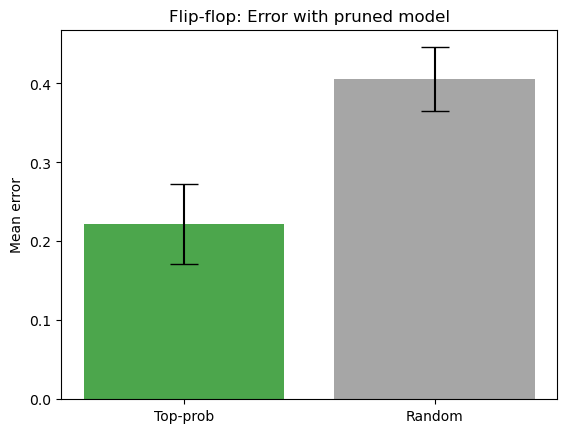

In [57]:
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=devs, align='center', alpha=0.7, ecolor='black', capsize=10, color=colours)

# Add labels and title
ax.set_ylabel('Mean error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Flip-flop: Error with pruned model')

#### Retraining: random training vs topprob training

In [58]:
min_losses = {}
for cntr in range(nRuns):
    min_losses[cntr] = test_losses[cntr][-1]
avg_min = sum(min_losses.values())/nRuns

In [59]:
min_losses

{0: 0.0028075006848666817,
 1: 0.00243748864158988,
 2: 0.0019775590917561203,
 3: 0.0012522740580607206,
 4: 0.003221450315322727}

In [60]:
n_fine = 40

In [61]:
def retrain(mp, pruned_rnn_weights, train_loss_min, train_loader, test_loader, num_epochs_finetune=n_fine):
    
    rnn_mask = torch.from_numpy((pruned_rnn_weights!=0).astype(int)).cuda()
    
    mp.rnn.weight_hh_l0.data = mp.rnn.weight_hh_l0.data.copy_(torch.from_numpy(pruned_rnn_weights).cuda())
    finetune_optimizer = optim.Adam(mp.parameters(), lr=learning_rate)
    
    test_losses = np.zeros((num_epochs_finetune))
    
    mp.train()
    for epoch in (range(1, num_epochs_finetune+1)):
        print(epoch)
    
        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader:
            if train_on_gpu:
                inputs, targets = torch.unsqueeze(inputs.float().cuda(),-1), torch.unsqueeze(targets.float().cuda(),-1)
                mp.cuda()
            else:
                inputs, targets = torch.unsqueeze(inputs.float(),-1), torch.unsqueeze(targets.float(),-1)

            finetune_optimizer.zero_grad()
            oops, frps = mp(inputs)
            if train_on_gpu:
                oops = oops.cuda()
            loss = criterion(oops, targets)
            loss.backward()
            finetune_optimizer.step()
            train_loss += loss.item()

            ## Dale's backprop
            w = mp.rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            mp.rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

            ## make sure sparsity mask is applied
            mp.rnn.weight_hh_l0.data = rnn_mask*mp.rnn.weight_hh_l0.data

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        for inputs_test, targets_test in test_loader:
            if train_on_gpu:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float().cuda(),-1), torch.unsqueeze(targets_test.float().cuda(),-1)
                mp.cuda()
            else:
                inputs_test, targets_test = torch.unsqueeze(inputs_test.float(),-1), torch.unsqueeze(targets_test.float(),-1)

            oops_test, frps_test = mp(inputs_test)
            if train_on_gpu:
                oops_test = oops_test.cuda()
            loss_test = criterion(outputs_test, targets_test)
            test_loss += loss_test.item()
            
        test_losses[epoch-1] = test_loss
        print(test_loss)
            
    return mp, test_losses

In [62]:
model_finetuned_random = {}
model_finetuned_topprob = {}

test_losses_finetuned_random = {}
test_losses_finetuned_topprob = {}

In [63]:
## retrain from ~90% sparse 

for run in tqdm(range(nRuns)):
    model_finetuned_random[run], test_losses_finetuned_random[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_random[run][2], min_losses[run], train_loader[run], test_loader[run])
    model_finetuned_topprob[run], test_losses_finetuned_topprob[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_topprob[run][2], min_losses[run], train_loader[run], test_loader[run])

  0%|          | 0/5 [00:00<?, ?it/s]

1
6.225666046142578
2
6.225666046142578
3
6.225666046142578
4
6.225666046142578
5
6.225666046142578
6
6.225666046142578
7
6.225666046142578
8
6.225666046142578
9
6.225666046142578
10
6.225666046142578
11
6.225666046142578
12
6.225666046142578
13
6.225666046142578
14
6.225666046142578
15
6.225666046142578
16
6.225666046142578
17
6.225666046142578
18
6.225666046142578
19
6.225666046142578
20
6.225666046142578
21
6.225666046142578
22
6.225666046142578
23
6.225666046142578
24
6.225666046142578
25
6.225666046142578
26
6.225666046142578
27
6.225666046142578
28
6.225666046142578
29
6.225666046142578
30
6.225666046142578
31
6.225666046142578
32
6.225666046142578
33
6.225666046142578
34
6.225666046142578
35
6.225666046142578
36
6.225666046142578
37
Epoch: 37, Train Loss Decreased!! (0.002808-->0.002797)
6.225666046142578
38
6.225666046142578
39
6.225666046142578
40


  0%|          | 0/5 [05:40<?, ?it/s]

6.225666046142578


NameError: name 'test_losses_finetuned_random' is not defined

In [ ]:
test_losses_finetuned_random_np = np.zeros((nRuns,n_fine))
test_losses_finetuned_topprob_np = np.zeros((nRuns,n_fine))

for cntr in range(nRuns):
    test_losses_finetuned_random_np[cntr] = test_losses_finetuned_random[cntr]
    test_losses_finetuned_topprob_np[cntr] = test_losses_finetuned_topprob[cntr]

In [ ]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_topprob_np,0), yerr=np.var(train_losses_finetuned_topprob_np,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_random_np,0), yerr=np.var(train_losses_finetuned_random_np,0),
             fmt='o', capsize=3, color='grey', label='Random')
plt.plot(np.arange(n_fine),[avg_min]*n_fine,'--',color='k',label='Original min. loss')

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Epochs retrained')
plt.title('0.9 Sparsity Losses with retraining: Flipflop')